In [1]:
import keras
import pandas as pd
from matplotlib import pyplot
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [6]:
def dateParser(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [7]:
airqdata = pd.read_csv("PRSA_Data_Dingling_20130301-20170228.csv", parse_dates = [['year', 'month', 'day', 'hour']] ,index_col = 0,date_parser=dateParser)
airqdata = airqdata.drop('No', axis = 1)
airqdata = airqdata.drop('station',axis = 1)
airqdata = airqdata.dropna(axis=0)
airqdata = airqdata.reset_index()
set1 = {'SE','S','SW','W','SSE','SSW','WNW','WSW'}
set2 = {'NW','N','NE','E','ENE','ESE','NNE','NNW'}
for i in range(0,airqdata.shape[0]):
    wd = airqdata.loc[i,'wd']
    ws = airqdata.loc[i,'WSPM']
    if wd in set1:
        if ws >= 0.0 and ws < 2.5:
            airqdata.loc[i,'wf'] = 4
        elif ws >= 2.5 and ws < 5:
            airqdata.loc[i,'wf'] = 2.5
        elif ws >= 5 and ws < 7.5:
            airqdata.loc[i,'wf'] = 2
        elif ws >= 7.5 and ws <= 10.0:
            airqdata.loc[i,'wf'] = 1
        else:
            airqdata.loc[i,'wf'] = 0
    elif wd in set2:
        if ws >= 0.0 and ws < 2.5:
            airqdata.loc[i,'wf'] = 4
        elif ws >= 2.5 and ws < 5:
            airqdata.loc[i,'wf'] = 2.5
        elif ws >= 5 and ws < 7.5:
            airqdata.loc[i,'wf'] = 2
        elif ws >= 7.5 and ws <= 10:
            airqdata.loc[i,'wf'] = 1.5
        else:
            airqdata.loc[i,'wf'] = 0
    else:
        airqdata.loc[i,'wf'] = 0
airqdata = airqdata.drop("wd",axis=1)
airqdata = airqdata.drop("WSPM",axis=1)
airqdata.set_index = 'year_month_day_hour'
airqdata.to_csv('pollution.csv')
airqdata = pd.read_csv('pollution.csv', header=0, index_col=0)

In [4]:
airqdata

,year_month_day_hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wf
0,2013-03-01 02:00:00,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,4.0
1,2013-03-01 05:00:00,6.0,6.0,3.0,4.0,200.0,79.0,-4.5,1022.6,-19.5,0.0,4.0
2,2013-03-01 06:00:00,5.0,10.0,3.0,4.0,200.0,77.0,-4.5,1023.4,-19.5,0.0,4.0
3,2013-03-01 07:00:00,5.0,6.0,3.0,2.0,200.0,80.0,-2.1,1024.6,-20.0,0.0,2.5
4,2013-03-01 08:00:00,8.0,7.0,3.0,3.0,200.0,79.0,-0.2,1025.2,-20.5,0.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...
31301,2017-02-28 19:00:00,11.0,11.0,2.0,2.0,200.0,99.0,11.7,1008.9,-13.3,0.0,4.0
31302,2017-02-28 20:00:00,13.0,13.0,2.0,2.0,200.0,101.0,10.9,1009.0,-14.0,0.0,4.0
31303,2017-02-28 21:00:00,9.0,14.0,2.0,2.0,200.0,102.0,9.5,1009.4,-13.0,0.0,4.0
31304,2017-02-28 22:00:00,10.0,12.0,2.0,2.0,200.0,97.0,7.8,1009.6,-12.6,0.0,4.0


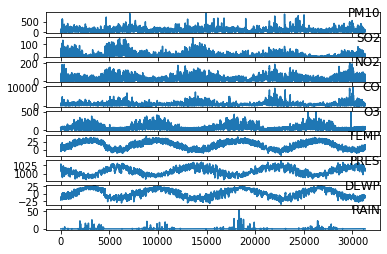

In [5]:
groups = [2, 3, 4, 5, 6, 7, 8, 9, 10]
values = airqdata.values
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(airqdata.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
airqdata = airqdata.drop('year_month_day_hour', axis = 1)
values = airqdata.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)

In [8]:
reframed.shape

(31305, 11)

In [9]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 10) (8760,) (22545, 1, 10) (22545,)


Train on 8760 samples, validate on 22545 samples
Epoch 1/50
 - 3s - loss: 0.1753 - val_loss: 0.0570
Epoch 2/50
 - 1s - loss: 0.0493 - val_loss: 0.0522
Epoch 3/50
 - 1s - loss: 0.0456 - val_loss: 0.0462
Epoch 4/50
 - 1s - loss: 0.0430 - val_loss: 0.0420
Epoch 5/50
 - 1s - loss: 0.0414 - val_loss: 0.0398
Epoch 6/50
 - 1s - loss: 0.0405 - val_loss: 0.0390
Epoch 7/50
 - 1s - loss: 0.0399 - val_loss: 0.0387
Epoch 8/50
 - 1s - loss: 0.0394 - val_loss: 0.0387
Epoch 9/50
 - 1s - loss: 0.0391 - val_loss: 0.0387
Epoch 10/50
 - 1s - loss: 0.0388 - val_loss: 0.0386
Epoch 11/50
 - 1s - loss: 0.0386 - val_loss: 0.0386
Epoch 12/50
 - 1s - loss: 0.0383 - val_loss: 0.0385
Epoch 13/50
 - 1s - loss: 0.0381 - val_loss: 0.0384
Epoch 14/50
 - 1s - loss: 0.0379 - val_loss: 0.0383
Epoch 15/50
 - 1s - loss: 0.0377 - val_loss: 0.0382
Epoch 16/50
 - 1s - loss: 0.0376 - val_loss: 0.0381
Epoch 17/50
 - 1s - loss: 0.0374 - val_loss: 0.0380
Epoch 18/50
 - 1s - loss: 0.0373 - val_loss: 0.0380
Epoch 19/50
 - 1s - loss

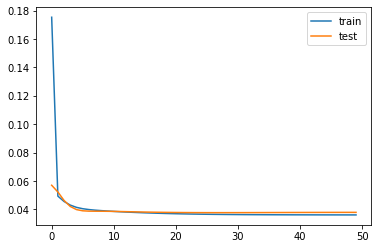

In [10]:
# design network
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95))
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
scaler = scaler.fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.132


In [12]:
print(test_X.shape)

(22545, 10)
